# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-warning">
<font color=black>

**What?** Forecasting multiple stock indeces (multi-outputs) with RNNs

</font>
</div>

# Multivariate = multi outputs

<div class="alert alert-info">
<font color=black>

- Univariate = just one output
- Multivariate = more than one output
- We'll build a RNN to predict the historical volatility of the **FTSE100** stock market index and the **Dow Jones Industrial** index.

</font>
</div>

# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import warnings
import copy
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import SGD
warnings.filterwarnings("ignore")

# Import dataset

In [2]:
loc = "../../DATASETS/stockindexes.xls"
Excel_file = pd.ExcelFile(loc)

In [3]:
# The excel file has multiple sheets. To visualise them use:
print(Excel_file.sheet_names)

['Description', 'Dow Jones Industrial', 'S&P500', 'NIKKEI 300', 'Dax30', 'CAC40', 'Swiss Market-Price Index', 'Mib30', 'IBEX 35I', 'Bel20', 'FTSE100']


In [4]:
# We want the ’FTSE100’ and ’Dow Jones Industrial’ worksheets:
ftse_data = Excel_file.parse("FTSE100")
dj_data = Excel_file.parse("Dow Jones Industrial")

# Data cleaning

In [5]:
ftse_data.head(10)

,Start,1995-11-30 00:00:00
0,End,2000-02-18 00:00:00
1,Frequency,D
2,Name,FTSE 100 - PRICE INDEX
3,Code,FTSE100
4,1995-11-30 00:00:00,3664.3
5,1995-12-01 00:00:00,3680.4
6,1995-12-04 00:00:00,3669.7
7,1995-12-05 00:00:00,3664.2
8,1995-12-06 00:00:00,3662.8
9,1995-12-07 00:00:00,3639.5


In [6]:
dj_data.head(10)

,Start,1995-11-30 00:00:00
0,End,2000-02-18 00:00:00
1,Frequency,D
2,Name,DOW JONES INDUSTRIALS - PRICE INDEX
3,Code,DJINDUS
4,1995-11-30 00:00:00,5074.49
5,1995-12-01 00:00:00,5087.13
6,1995-12-04 00:00:00,5139.52
7,1995-12-05 00:00:00,5177.45
8,1995-12-06 00:00:00,5199.13
9,1995-12-07 00:00:00,5159.39


In [7]:
# Let's skip the first 4 line as they are just a description of the file
ftse100 = ftse_data.iloc[4:1357, 1]
dj = dj_data.iloc[4:1357, 1]

In [8]:
ftse100.head()

4    3664.3
5    3680.4
6    3669.7
7    3664.2
8    3662.8
Name: 1995-11-30 00:00:00, dtype: object

In [9]:
dj.head()

4    5074.49
5    5087.13
6    5139.52
7    5177.45
8    5199.13
Name: 1995-11-30 00:00:00, dtype: object

<div class="alert alert-block alert-info">
<font color=black>

- The goal is to predict the 30 day historical volatility of the daily price change.
- Volatility is just a fancy name for standard deviation. 

</font>
</div>

In [10]:
# Let's concatenate along the column. Essentially adding an extra column 
yt = pd.concat([ftse100, dj], axis = 1)

In [11]:
yt.head()

,1995-11-30,1995-11-30
4,3664.3,5074.49
5,3680.4,5087.13
6,3669.7,5139.52
7,3664.2,5177.45
8,3662.8,5199.13


In [12]:
# Reset the index
yt = yt.reset_index(drop = True) 

In [13]:
yt.head()

,1995-11-30,1995-11-30
0,3664.3,5074.49
1,3680.4,5087.13
2,3669.7,5139.52
3,3664.2,5177.45
4,3662.8,5199.13


In [14]:
# Change the column name
yt.columns = ["ftse100", "dj"]

In [15]:
yt.head()

,ftse100,dj
0,3664.3,5074.49
1,3680.4,5087.13
2,3669.7,5139.52
3,3664.2,5177.45
4,3662.8,5199.13


In [16]:
rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

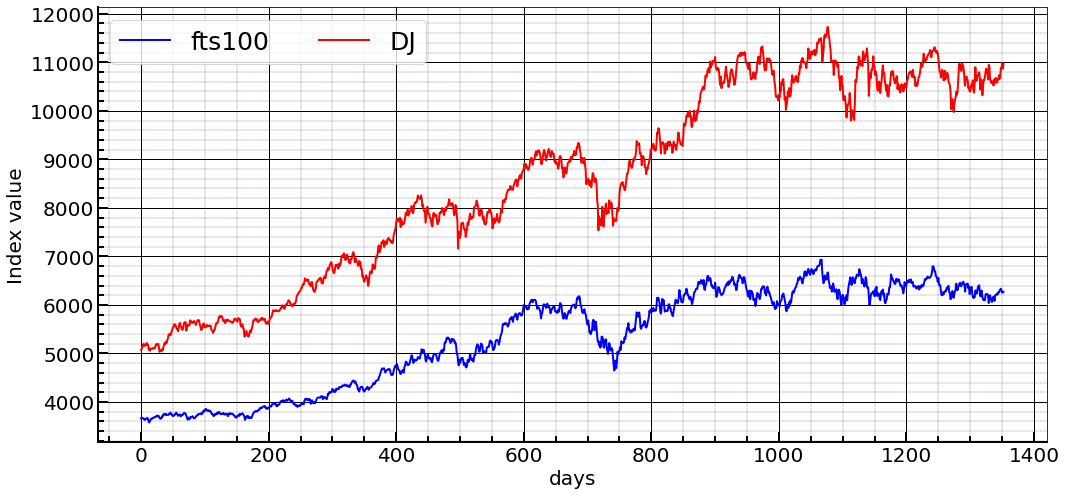

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(yt.index.values, yt["ftse100"], "-b", lw=2, label="fts100")
plt.plot(yt.index.values, yt["dj"], "-r", lw=2, label="DJ")

ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("days")
ax.set_ylabel("Index value")

plt.legend(loc='upper left', ncol=4, fontsize=25)

# Feature engineering

<div class="alert alert-block alert-info">
<font color=black>

- Convert the price levels into **daily price percent changes** with `pct_change(1)`
- Calculate the 30 day **rolling standard deviation**.

</font>
</div>

In [18]:
# Periods to shift for forming percent change.
yt_pct = yt.pct_change(periods = 1)

In [19]:
yt_pct.head()

,ftse100,dj
0,NaN,NaN
1,0.004394,0.002491
2,-0.002907,0.010299
3,-0.001499,0.007380
4,-0.000382,0.004187


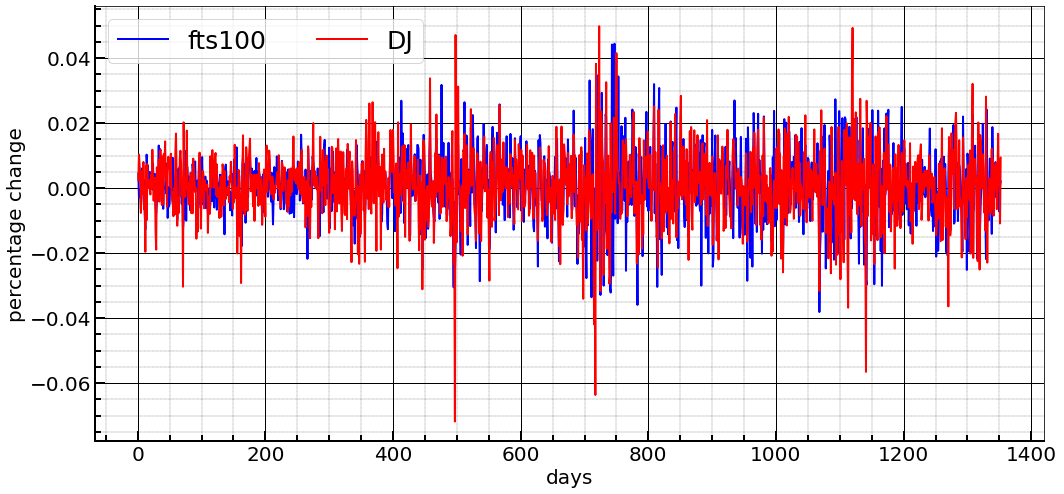

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(yt_pct.index.values, yt_pct["ftse100"], "-b", lw=2, label="fts100")
plt.plot(yt_pct.index.values, yt_pct["dj"], "-r", lw=2, label="DJ")

ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("days")
ax.set_ylabel("percentage change")

plt.legend(loc='upper left', ncol=4, fontsize=25)

In [21]:
yt_pct.shape

(1353, 2)

In [22]:
1353/30

45.1

In [23]:
# min_periods = 1 otherwise you get NaN
volatility = yt_pct.rolling(window = 30, center = True, min_periods = 1).std()
volatility = pd.DataFrame(volatility)
volatility

,ftse100,dj
0,0.006025,0.008377
1,0.006037,0.008303
2,0.006121,0.008022
3,0.005926,0.007767
4,0.005749,0.007552
...,...,...
1348,0.007418,0.007635
1349,0.007143,0.007699
1350,0.007185,0.007918
1351,0.007173,0.008154


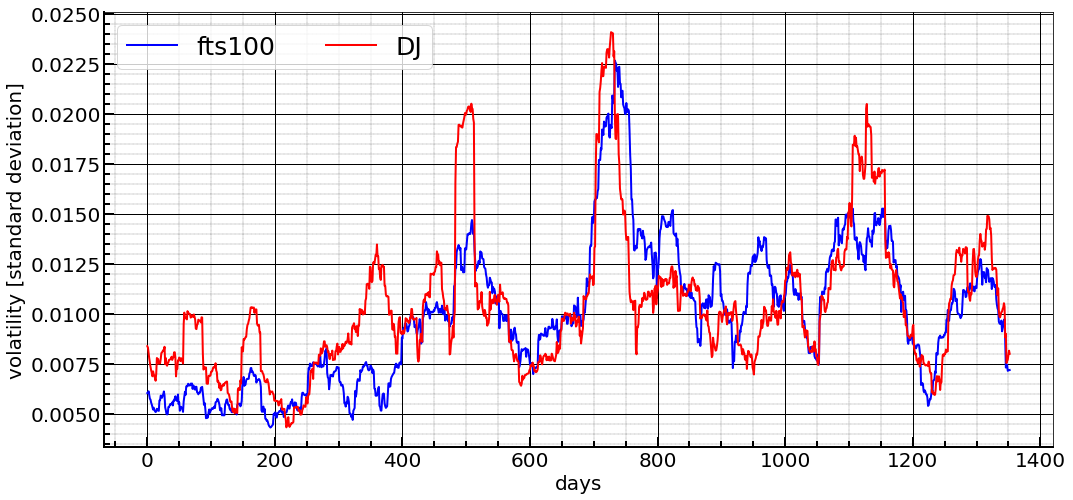

In [24]:
fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(volatility.index.values, volatility["ftse100"], "-b", lw = 2, label = "fts100")
plt.plot(volatility.index.values, volatility["dj"], "-r", lw = 2, label = "DJ")

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("days")
ax.set_ylabel("volatility [standard deviation]")

plt.legend(loc = 'upper left', ncol = 4, fontsize = 25)

<div class="alert alert-block alert-info">
<font color=black>

- We'll add an extra feature constructed like this.
- At time t we use yesterday’s volatility adjusted by the ratio of it to recent past values:

</font>
</div>

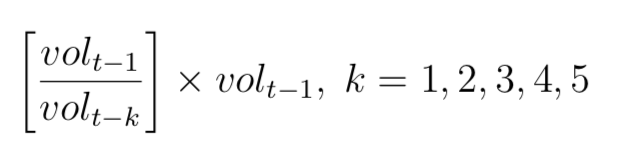

In [25]:
vol_t = copy.deepcopy(volatility)

In [26]:
x1 = np.log ( ( vol_t.shift(1) / vol_t.shift(2)) * vol_t.shift(1))
x2 = np.log ( ( vol_t.shift(1) / vol_t.shift(3)) * vol_t.shift(1))
x3 = np.log ( ( vol_t.shift(1) / vol_t.shift(4)) * vol_t.shift(1))
x4 = np.log ( ( vol_t.shift(1) / vol_t.shift(5)) * vol_t.shift(1))
x5 = np.log ( ( vol_t.shift(1) / vol_t.shift(6)) * vol_t.shift(1))

In [27]:
# Rearranging by column
data = pd.concat([vol_t,x1,x2,x3,x4,x5], axis = 1)

# gGiving the column some names
data.columns = ["tse_t", "dj_t", "ftse_t-1","dj_t-1",
"ftse_t-2", "dj_t-2", "ftse_t-3", "dj_t-3", "ftse_t-4", "dj_t-4", "ftse_t-5", "dj_t-5"]

# Dropping NaN
data = data.dropna()

In [28]:
data

,tse_t,dj_t,ftse_t-1,dj_t-1,ftse_t-2,dj_t-2,ftse_t-3,dj_t-3,ftse_t-4,dj_t-4,ftse_t-5,dj_t-5
6,0.005553,0.007168,-5.174146,-4.941572,-5.204453,-4.969710,-5.236716,-5.001929,-5.222903,-5.036425,-5.221018,-5.045239
7,0.005458,0.007039,-5.220443,-4.962533,-5.228195,-4.990329,-5.258501,-5.018467,-5.290765,-5.050687,-5.276952,-5.085182
8,0.005327,0.006870,-5.227756,-4.974342,-5.254781,-4.998721,-5.262532,-5.026517,-5.292839,-5.054655,-5.325102,-5.086874
9,0.005207,0.007120,-5.259195,-5.004867,-5.276363,-5.022961,-5.303388,-5.047339,-5.311139,-5.075135,-5.341446,-5.103273
10,0.005301,0.006979,-5.280620,-4.909184,-5.304924,-4.933493,-5.322093,-4.951587,-5.349117,-4.975966,-5.356868,-5.003762
...,...,...,...,...,...,...,...,...,...,...,...,...
1348,0.007418,0.007635,-4.871837,-5.065341,-5.041458,-5.045147,-5.158344,-5.205253,-5.152186,-5.222462,-5.131801,-5.202142
1349,0.007143,0.007699,-4.912414,-4.861902,-4.888909,-5.039161,-5.058530,-5.018967,-5.175417,-5.179073,-5.169259,-5.196282
1350,0.007185,0.007918,-4.979321,-4.858379,-4.987858,-4.845289,-4.964353,-5.022547,-5.133974,-5.002354,-5.250861,-5.162460
1351,0.007173,0.008154,-4.929818,-4.810614,-4.967540,-4.802307,-4.976076,-4.789218,-4.952572,-4.966476,-5.122193,-4.946283


# Data scaling

In [29]:
cols_y = ["tse_t", "dj_t"]
y = data[cols_y] 
cols = ["ftse_t-1","dj_t-1", "ftse_t-2", "dj_t-2", "ftse_t-3", "dj_t-3", "ftse_t-4", "dj_t-4", "ftse_t-5", "dj_t-5"]
x = data[cols]

In [30]:
num_attrib = 10
scaler_x = preprocessing.MinMaxScaler(
feature_range=(-1, 1))
x = np.array(x).reshape((len(x), num_attrib))
x = scaler_x.fit_transform(x)

num_response = 2
scaler_y = preprocessing.MinMaxScaler( feature_range=(0, 1))
y = np.array(y).reshape((len(y), num_response))
y = scaler_y.fit_transform(y)

# Train and test

<div class="alert alert-block alert-info">
<font color=black>

- Re-frame the problem using multiple time-steps (10 in this case). 
- Therefore, the test set has 1131 examples on 10 time steps.

</font>
</div>

In [43]:
train_end = 1131
data_end =len(y)
x_train = x[0:train_end ,] 
x_test = x[train_end+1:data_end ,] 
y_train = y[0:train_end] 
y_test = y[train_end+1:data_end]

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
print(x_test.shape)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

(215, 10)


In [32]:
print("Shape of x_train is ", x_train.shape)
print("Shape of x_test is ", x_test.shape)

Shape of x_train is  (1131, 1, 10)
Shape of x_test is  (215, 1, 10)


# Modelling and fitting

<div class="alert alert-block alert-info">
<font color=black>

- The model is a simple RNN built using the Keras package. 
- We will specify 10 nodes in the hidden layer, use Stochastic Gradient Descent with a learning rate of 0.01 and a momentum of 0.90, with the model run over 20 epoches.  

</font>
</div>

In [100]:
seed =2016
np.random.seed(seed)
fit1 = Sequential() 

# return_sequences = True is fundamentalw when stacking RNNs
fit1.add(SimpleRNN(units = 10, return_sequences = True, activation = "sigmoid", input_shape = (1, num_attrib))) 
fit1.add(SimpleRNN(units = 10, activation = "sigmoid"))  
fit1.add(Dense(units = num_response , activation = "linear"))

10


In [101]:
sgd = SGD(lr = 0.01, momentum = 0.90, nesterov = True)
fit1.compile(loss = "mean_squared_error", optimizer = sgd)
history = fit1.fit(x_train, y_train , batch_size = 1, epochs = 50)

Epoch 1/50
1131/1131 [==============================] - 3s 1ms/step - loss: 0.0481
Epoch 2/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0076
Epoch 3/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0057
Epoch 4/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0044
Epoch 5/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0036
Epoch 6/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0030
Epoch 7/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0030
Epoch 8/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0026
Epoch 9/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0024
Epoch 10/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0024
Epoch 11/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0022
Epoch 12/50
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0024
E

In [102]:
def plotLearningHistory(history):
    """Plot learning history.
    """
    
    epochs = len(history.history[ "loss"]) 
    x = range(0, epochs)

    rcParams['figure.figsize'] = 15, 5
    rcParams['font.size'] = 20

    fig, ax = plt.subplots()
    ax.plot(x, history.history[ "loss"], 'r-', lw = 3, label = 'Train') 

    ax.legend() 
    plt.xlabel('Epochs')
    plt.ylabel("MSE")
    plt.title('Training history')

    ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which = 'major', direction='in', length=10, width=2)
    ax.tick_params(which = 'minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    plt.yscale('log')
    ax.minorticks_on()
    plt.show()

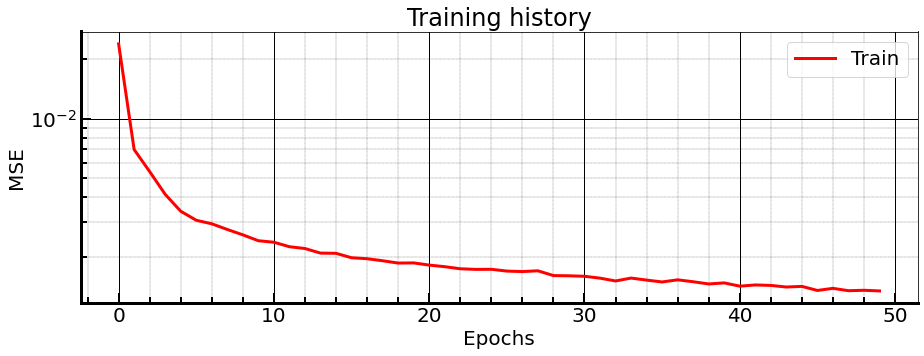

In [103]:
plotLearningHistory(history)

In [104]:
score_train = fit1.evaluate(x_train, y_train, batch_size = 1)
score_test = fit1.evaluate(x_test, y_test, batch_size = 1)

215/215 [==============================] - 0s 725us/step - loss: 0.0010


In [105]:
print("Train score", score_train)
print("Test score", score_test)

Train score 0.0012315738713368773
Test score 0.0010168938897550106


In [106]:
pred1 = fit1.predict(x_test)
#pred1 = scaler_y.inverse_transform(np.array(pred1).reshape((len(pred1), 2)))

In [121]:
print(y_test.shape)
a = y_test[:,0]
print(a.shape)

(215, 2)
(215,)


In [119]:
pred1.shape

(215, 2)

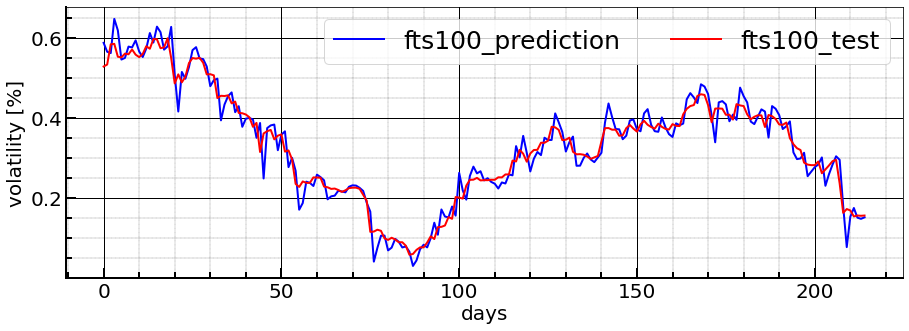

In [122]:
fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(range(len(pred1[:,0])), pred1[:,0], "-b", lw = 2, label = "fts100_prediction")
plt.plot(range(len(y_test[:,0])), y_test[:,0], "-r", lw = 2, label = "fts100_test")

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("days")
ax.set_ylabel("volatility [%]")

plt.legend(loc = 'best', ncol = 4, fontsize = 25)

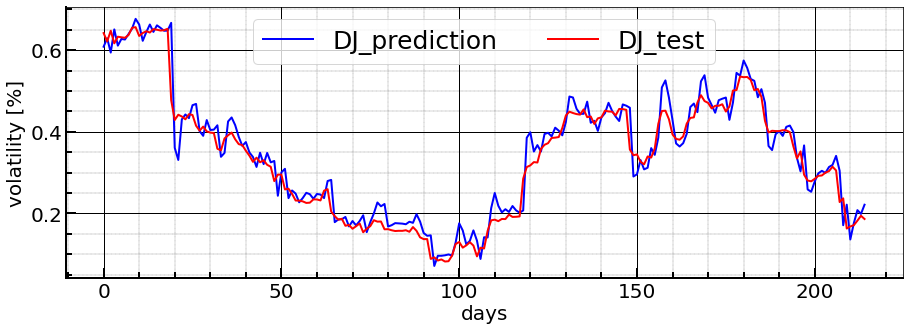

In [124]:
fig = plt.figure() 
ax = fig.add_subplot(111) 

plt.plot(range(len(pred1[:,1])), pred1[:,1], "-b", lw = 2, label = "DJ_prediction")
plt.plot(range(len(y_test[:,1])), y_test[:,1], "-r", lw = 2, label = "DJ_test")

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)

ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.set_xlabel("days")
ax.set_ylabel("volatility [%]")

plt.legend(loc = 'best', ncol = 4, fontsize = 25)

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- Lewis, N. D. "Deep Time Series Forecasting with Python." Create Space Independent Publishing Platform (2016).
- [Download dataset](http://www.economicswebinstitute.org/data/stockindexes.zip)
- [How to avoid pandas rolling to return NaN]([https://stackoverflow.com/questions/40814201/pandas-rolling-gives-nan)

</font>
</div>